In [1]:
%load_ext autoreload

In [2]:
%autoreload

import numpy as np
import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import corner
import jacket.hmc as hmc

\begin{align}
y &\sim \mathcal{N}(\beta_0 + \beta_1 x, \sigma) \\
\beta_0 &\sim \mathcal{N}(0, 1) \\
\beta_1 &\sim \mathcal{N}(0, 1) \\
\sigma &\sim Exp(1)
\end{align}

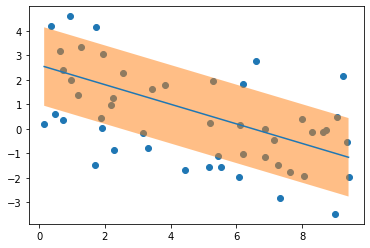

In [3]:
beta0 = 2.6
beta1 = -0.4
sigma = 1.6
n = 50

x = jnp.array(np.sort(np.random.uniform(0., 10., size=n)))
ymean = beta0 + beta1 * x
y = jnp.array(np.random.normal(ymean, sigma))

plt.scatter(x, y)
plt.plot(x, ymean)
plt.fill_between(x, ymean - sigma, ymean + sigma, alpha=0.5)

In [4]:
def ln_prior(params):
    beta0, beta1, sigma = params
    target = 0
    target += stats.norm.logpdf(beta0, 1., 3.)
    target += stats.norm.logpdf(beta1, 0., 1.)
    target += stats.expon.logpdf(jnp.exp(sigma))
    return target.sum()

def ln_likelihood(params, data):
    beta0, beta1, sigma = params
    x, y = data[:,0], data[:,1]
    return stats.norm.logpdf(y, beta0 + beta1 * x, jnp.exp(sigma)).sum()

def ln_posterior(params, data):
    return ln_prior(params) + ln_likelihood(params, data)

@jax.jit
def ln_unnormalized_posterior(params):
    return ln_posterior(params, jnp.stack((x, y)).T)

In [5]:
k = jax.random.PRNGKey(0)
samples, momentum, paccepts, mle = hmc.sample(ln_unnormalized_posterior, 1000, 10, 5e-3, 1000, 0.1, 3, 500, k)

100%|████████████████████████████████████████████| 1000/1000 [00:07<00:00, 134.08it/s]


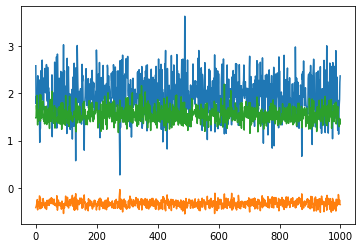

In [6]:
plt.plot(samples[:,0])
plt.plot(samples[:,1])
plt.plot(jnp.exp(samples[:,2]))

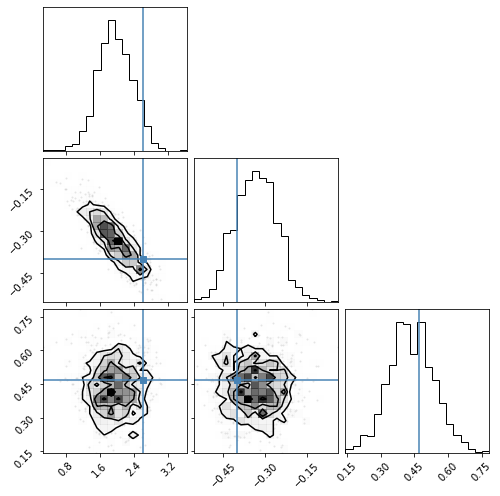

In [7]:
corner.corner(np.array(samples), truths=(beta0, beta1, jnp.log(sigma)));

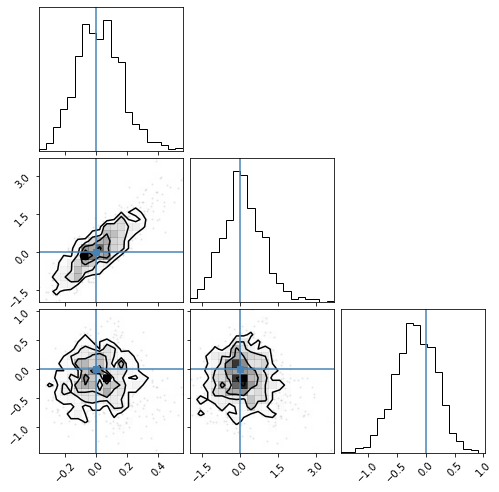

In [8]:
corner.corner(np.array(momentum), truths=np.zeros(3));